ワークスペース内で発見: c:\Users\tokot\code\image-processing\all\CIFAR-10_data\cifar-10-batches-py
活性化関数を **Sigmoid** に設定しました。
パラメータ更新に慣性項 **0.9** を使用します。

--- 訓練モード実行中 ---
1エポック目
 平均クロスエントロピー誤差: 2.4134444161315596
 学習データに対する正答率: 0.3109199999999998
 テストデータに対する正答率: 0.3724
2エポック目
 平均クロスエントロピー誤差: 1.7966734490499516
 学習データに対する正答率: 0.3815799999999995
 テストデータに対する正答率: 0.3661
3エポック目
 平均クロスエントロピー誤差: 1.7126363165662852
 学習データに対する正答率: 0.41047999999999923
 テストデータに対する正答率: 0.4025
4エポック目
 平均クロスエントロピー誤差: 1.6672116913688622
 学習データに対する正答率: 0.42673999999999956
 テストデータに対する正答率: 0.4291
5エポック目
 平均クロスエントロピー誤差: 1.6108324359207526
 学習データに対する正答率: 0.4457799999999998
 テストデータに対する正答率: 0.4305
6エポック目
 平均クロスエントロピー誤差: 1.5455918240040056
 学習データに対する正答率: 0.46452
 テストデータに対する正答率: 0.4629
7エポック目
 平均クロスエントロピー誤差: 1.4884016743724247
 学習データに対する正答率: 0.48614000000000024
 テストデータに対する正答率: 0.4241
8エポック目
 平均クロスエントロピー誤差: 1.434463725987955
 学習データに対する正答率: 0.5062000000000004
 テストデータに対する正答率: 0.4895
9エポック目
 平均クロスエントロピー誤差: 1.3852766999758195
 学習データに対する正答率

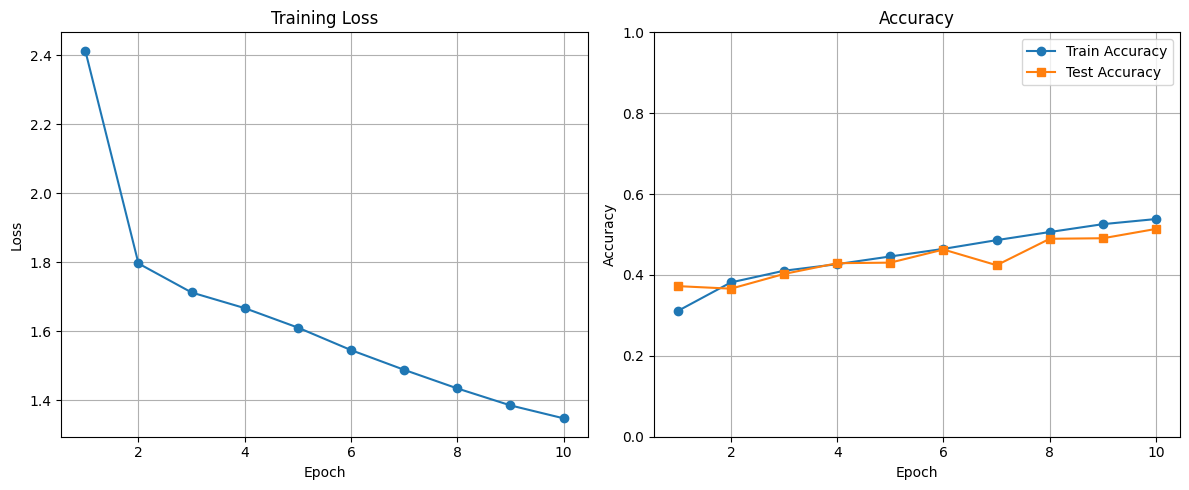

In [10]:
import os
from pathlib import Path
import urllib.request
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

POOL_SIZE = 2
POOL_STRIDE = 2
ACTIVATION_FUNC = ""

def ensure_cifar(data_dir="all/cifar-10-batches-py"):
    data_dir = Path(data_dir)
    # 既に指定パスに存在すれば返す
    if (data_dir / "data_batch_1").exists():
        print("CIFAR-10 データは既に存在します:", data_dir)
        return str(data_dir)

    # ワークスペース内を探索して見つかれば返す
    ws_root = Path(r"c:\Users\tokot\code\image-processing")
    for p in ws_root.rglob("data_batch_1"):
        print("ワークスペース内で発見:", p.parent)
        return str(p.parent)

    # 見つからなければダウンロードして展開
    print("CIFAR-10 が見つかりません。ダウンロードを開始します...")
    dest = ws_root / "cifar-10-python.tar.gz"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    try:
        urllib.request.urlretrieve(url, dest)
        print("ダウンロード完了:", dest)
        with tarfile.open(dest, "r:gz") as tf:
            tf.extractall(path=ws_root)
        extracted = ws_root / "cifar-10-batches-py"
        if (extracted / "data_batch_1").exists():
            print("展開完了:", extracted)
            return str(extracted)
        raise FileNotFoundError("展開後に期待ファイルが見つかりません")
    except Exception as e:
        print("取得失敗:", e)
        raise

def load_cifar10(data_dir):
    """ (N,3072) の train/test とラベルを返す（float32 0-1 正規化） """
    train_data = None
    train_labels = []
    data_dir = str(data_dir)
    for i in range(1, 6):
        path = os.path.join(data_dir, f"data_batch_{i}")
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        with open(path, "rb") as f:
            data_dict = pickle.load(f, encoding="bytes")
            if train_data is None:
                train_data = data_dict[b"data"]
            else:
                train_data = np.vstack((train_data, data_dict[b"data"]))
            train_labels.extend(data_dict[b"labels"])
    test_path = os.path.join(data_dir, "test_batch")
    with open(test_path, "rb") as f:
        data_dict = pickle.load(f, encoding="bytes")
        test_data = data_dict[b"data"]
        test_labels = data_dict[b"labels"]

    train_data = np.array(train_data, dtype=np.float32) / 255.0
    test_data = np.array(test_data, dtype=np.float32) / 255.0
    train_labels = np.array(train_labels, dtype=np.int64)
    test_labels = np.array(test_labels, dtype=np.int64)
    return train_data, train_labels, test_data, test_labels


def padding_data(train_images, test_images, pad=1):
    # (N, 3072) -> (N, 3, 32, 32) -> (N, 32, 32, 3)
    train_imgs = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_imgs = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    padded_train = np.pad(
        train_imgs,
        ((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode="constant",
        constant_values=0.0,
    )
    padded_test = np.pad(
        test_imgs,
        ((0, 0), (pad, pad), (pad, pad), (0, 0)),
        mode="constant",
        constant_values=0.0,
    )

    return padded_train, padded_test


def im2col(padding_data, filter_size, stride=1, pad=0):
    N, H, W, C = padding_data.shape
    
    # 出力特徴マップのサイズ計算
    out_h = (H - filter_size) // stride + 1
    out_w = (W - filter_size) // stride + 1
    
    col = np.zeros((N, out_h, out_w, filter_size, filter_size, C))

    for i in range(out_h):
        i_max = i * stride + filter_size
        for j in range(out_w):
            j_max = j * stride + filter_size
            
            # パッチを抽出
            col[:, i, j, :, :, :] = padding_data[:, i * stride:i_max, j * stride:j_max, :]
            
    # 形状を (R*R*C, N*out_h*out_w) に変換（行列乗算の形式）
    col = col.reshape(-1, filter_size * filter_size * C).T
    
    return col

def set_filter_weights():
    K = 32  # フィルタ枚数
    R = 3   # フィルタサイズ
    ch = 3  # 入力チャネル数
    input_node_count = R * R * ch 
    std_dev = np.sqrt(2.0 / input_node_count)
    # 形状は (K, R*R*ch) = (32, 27)
    W = std_dev * np.random.randn(K, R * R * ch)
    
    return W, R

def set_biases():
    K = 32  # フィルタ枚数
    b = np.random.normal(loc=0.0, scale=0.01, size=K)
    b_vector = b.reshape(-1, 1)
    
    return b_vector

def get_shuffled_index(arr):
    index_arr = np.arange(len(arr)) 
    np.random.shuffle(index_arr) 
    return index_arr

def get_batch(random_index): 
    # ベクトルとラベルをまとめて取得
    batch_images = padded_train_images[random_index]
    batch_labels = train_labels[random_index]
    return batch_images, batch_labels

def get_one_hot_label(batch_labels, output_layer_size):
    one_hot_labels = np.zeros((batch_labels.size, output_layer_size)) 
    one_hot_labels[np.arange(batch_labels.size), batch_labels] = 1 
    return one_hot_labels

def conv_forward(padded_data, conv_W, conv_b_vector, filter_size, stride=1):
    # 畳み込み層の順伝播 (Y = WX + B)
    N, H_prime, W_prime, C = padded_data.shape
    K, _ = conv_W.shape
    
    # Im2col変換: (N, H', W', C) -> (R*R*C, N*out_h*out_w)
    col = im2col(padded_data, filter_size, stride=stride, pad=0)
    
    # 行列積による畳み込み計算: Y = WX
    # W: (K, R*R*C) @ X: (R*R*C, N*out_h*out_w) -> Y: (K, N*out_h*out_w)
    conv_out = np.dot(conv_W, col)
    
    # バイアスの加算
    conv_out += conv_b_vector
    
    # 出力特徴マップの形状に戻す
    out_h = (H_prime - filter_size) // stride + 1 
    out_w = (W_prime - filter_size) // stride + 1 
    
    # (K, N*out_h*out_w) -> (N*out_h*out_w, K) -> (N, out_h, out_w, K)
    output = conv_out.T.reshape(N, out_h, out_w, K)
    
    return output, col

# 畳み込み層の逆伝播関数
def conv_backward(dY_4d, col):

    N, out_h, out_w, K = dY_4d.shape
    
    # dY_4d (N, out_h, out_w, K) を dY (K, N*out_h*out_w) に整形
    dY = dY_4d.transpose(3, 0, 1, 2).reshape(K, N * out_h * out_w)
        
    dW = np.dot(dY, col.T) # (K, R*R*C)
    
    db_vector = np.sum(dY, axis=1, keepdims=True) # (K, 1)
    
    return dW, db_vector

np.random.seed(777) 

def ReLU(arr):
    """ReLU活性化関数"""
    new_arr = np.where(arr > 0, arr, 0)
    return new_arr

def Sigmoid(arr):
    """Sigmoid活性化関数"""
    return 1 / (1 + np.exp(-arr))

def sigmoid_grad(out):
    """Sigmoid関数の勾配 (順伝播の出力 out を使用)"""
    return out * (1.0 - out)

def softmax(x):
    """ソフトマックス関数"""
    alpha = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - alpha)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def max_pooling_forward(conv_output_4d, pool_h=POOL_SIZE, pool_w=POOL_SIZE, stride=POOL_STRIDE):

    N, H, W, C = conv_output_4d.shape
    out_h = (H - pool_h) // stride + 1
    out_w = (W - pool_w) // stride + 1

    # 領域を抽出 (N, out_h, out_w, pool_h, pool_w, C)
    # im2col と同様の処理でパッチを抽出
    col = np.zeros((N, out_h, out_w, pool_h, pool_w, C))

    for i in range(out_h):
        i_max = i * stride + pool_h
        for j in range(out_w):
            j_max = j * stride + pool_w
            col[:, i, j, :, :, :] = conv_output_4d[:, i * stride:i_max, j * stride:j_max, :]
            
    # 最大値を計算するために整形 (N*out_h*out_w, pool_h*pool_w, C)
    col_max_calc = col.reshape(N * out_h * out_w, pool_h * pool_w, C)
    
    # 最大値とインデックスを取得
    out_flat = np.max(col_max_calc, axis=1)     # (N*out_h*out_w, C)
    max_idx = np.argmax(col_max_calc, axis=1)   # (N*out_h*out_w, C)

    # 出力形状に戻す (N, out_h, out_w, C)
    out = out_flat.reshape(N, out_h, out_w, C)
    
    return out, max_idx, conv_output_4d.shape

def max_pooling_backward(dY, max_idx, input_shape, pool_h=POOL_SIZE, pool_w=POOL_SIZE, stride=POOL_STRIDE):

    N, H, W, C = input_shape
    out_h = dY.shape[1]
    out_w = dY.shape[2]
    
    # dYを (N*out_h*out_w, C) に再整形
    dY_flat = dY.reshape(-1, C)

    # dXをIm2colの形状 (N*out_h*out_w, pool_h*pool_w, C) で初期化
    dX_col = np.zeros((dY_flat.shape[0], pool_h * pool_w, C))
    
    idx_flat = np.arange(dY_flat.shape[0])[:, None]
    
    # dX_col[行インデックス, 縦横インデックス, チャンネルインデックス] = 値
    dX_col[idx_flat, max_idx, np.arange(C)[None, :]] = dY_flat
    
    # dX_colを (N, out_h, out_w, pool_h, pool_w, C) の形状に戻す
    dX_col = dX_col.reshape(N, out_h, out_w, pool_h, pool_w, C)
    
    # dXを (N, H, W, C) に再構成
    dX = np.zeros(input_shape)
    
    for i in range(out_h):
        i_max = i * stride + pool_h
        for j in range(out_w):
            j_max = j * stride + pool_w
            # dX_colのパッチを元の位置に加算
            dX[:, i * stride:i_max, j * stride:j_max, :] += dX_col[:, i, j, :, :, :]
    
    return dX


def forward_propagation(input_data_4d, conv_W, conv_b_vector, conv_R, weight2, bias2):
    global ACTIVATION_FUNC
    
    # 畳み込み層
    conv_output_pre_act, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    
    # Max Pooling層
    pool_output, pool_mask, pool_input_shape = max_pooling_forward(conv_output_pre_act)
    
    # 活性化関数
    if ACTIVATION_FUNC == "ReLU":
        conv_output_act = ReLU(pool_output)
    elif ACTIVATION_FUNC == "Sigmoid":
        conv_output_act = Sigmoid(pool_output)
    else:
        raise ValueError("無効な活性化関数が設定されています")

    # 全結合層への入力のために平坦化
    input_vector_fc = conv_output_act.reshape(conv_output_act.shape[0], -1) 
    
    # 全結合層 
    output_layer_input = np.dot(input_vector_fc, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    # 逆伝播に必要な情報をまとめて返す 
    return final_output, input_vector_fc, conv_output_pre_act, col, pool_mask, pool_input_shape, conv_output_act

def forward_propagation_train(input_data_4d, conv_W, conv_b_vector, conv_R, weight2, bias2, ignore_number):
    global ACTIVATION_FUNC
    
    # 畳み込み層
    conv_output_pre_act, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    
    # Max Pooling層
    pool_output, pool_mask, pool_input_shape = max_pooling_forward(conv_output_pre_act)
    
    # 活性化関数
    if ACTIVATION_FUNC == "ReLU":
        conv_output_act = ReLU(pool_output)
    elif ACTIVATION_FUNC == "Sigmoid":
        conv_output_act = Sigmoid(pool_output)
    else:
        raise ValueError("無効な活性化関数が設定されています")
    
    # 全結合層への入力のために平坦化
    input_vector_fc = conv_output_act.reshape(conv_output_act.shape[0], -1) 
    
    # ドロップアウト適用 (全結合層への入力に適用)
    hidden_layer_output = input_vector_fc.copy() 
    for index in ignore_number:
        hidden_layer_output[:, index] = 0
        
    # 全結合層
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    # 逆伝播に必要な情報を全て返す
    return final_output, hidden_layer_output, conv_output_pre_act, col, pool_mask, pool_input_shape, conv_output_act

def forward_propagation_test(input_data_4d, conv_W, conv_b_vector, conv_R, weight2, bias2, ignore_number):
    global ACTIVATION_FUNC
    
    # 畳み込み層
    conv_output_pre_act, col = conv_forward(input_data_4d, conv_W, conv_b_vector, conv_R, stride=1) 
    
    # Max Pooling層
    pool_output, pool_mask, pool_input_shape = max_pooling_forward(conv_output_pre_act)
    
    # 活性化関数
    if ACTIVATION_FUNC == "ReLU":
        conv_output_act = ReLU(pool_output)
    elif ACTIVATION_FUNC == "Sigmoid":
        conv_output_act = Sigmoid(pool_output)
    else:
        raise ValueError("無効な活性化関数が設定されています")
    
    # 全結合層への入力のために平坦化
    input_vector_fc = conv_output_act.reshape(conv_output_act.shape[0], -1) 
    
    hidden_layer_output = input_vector_fc * (1 - (len(ignore_number) / fc_input_size)) 
    
    # 全結合層
    output_layer_input = np.dot(hidden_layer_output, weight2.T) + bias2
    final_output = softmax(output_layer_input)
    
    # テスト時は逆伝播情報が不要なので、ダミーを返す
    return final_output, hidden_layer_output, None, None, None, None, None

def get_predicted_class(output_probabilities):
    if output_probabilities.ndim == 1:
        return np.argmax(output_probabilities)
    else:
        return np.argmax(output_probabilities, axis=1)

def get_cross_entropy_error(y_pred, y_true):
    delta = 1e-7
    loss = -np.sum(y_true * np.log(y_pred + delta)) 
    batch_size = y_pred.shape[0]
    cross_entropy_error = loss / batch_size
    return cross_entropy_error

def get_accuracy(y_prop, y_true): 
    y_pred = get_predicted_class(y_prop) 
    accuracy = np.sum(y_pred == y_true) / len(y_prop)
    return accuracy

def calculate_accuracy_for_epoch(images, labels, conv_W, conv_b_vector, conv_R, weight2, bias2, mode, ignore_number):
    """
    指定されたデータセットに対するモデルの正答率を計算する関数。
    """
    if mode == 'train':
        probabilities, _, _, _, _, _, _ = forward_propagation_train(images, conv_W, conv_b_vector, conv_R, weight2, bias2, ignore_number)
    elif mode == 'test':
        probabilities, _, _, _, _, _, _ = forward_propagation_test(images, conv_W, conv_b_vector, conv_R, weight2, bias2, ignore_number)
    else:
        probabilities, _, _, _, _, _, _ = forward_propagation(images, conv_W, conv_b_vector, conv_R, weight2, bias2)

    accuracy = get_accuracy(probabilities, labels)

    return accuracy

def backward_propagation_and_update_train(hidden_layer_output, output_probabilities, one_hot_labels, 
                                          weight2, bias2, learning_rate, ignore_number, momentum, prev_delta_W2,
                                          conv_output_pre_act, col, pool_mask, pool_input_shape, conv_output_act):
    """
    全結合層の逆伝播、パラメータ更新、および勾配計算後の畳み込み層への誤差伝播を行う。
    """
    current_batch_size = hidden_layer_output.shape[0]
    
    # --- 全結合層 (weight2) の逆伝播 ---
    # 誤差 dEn_dak は Softmax の後の勾配
    dEn_dak = (output_probabilities - one_hot_labels) / current_batch_size  # (N, Output_K)
    
    # 全結合層の勾配計算
    dEn_dW2 = np.dot(dEn_dak.T, hidden_layer_output)  # (Output_K, FC_Input_Size)
    dEn_db2 = np.sum(dEn_dak, axis=0)  # (Output_K,)

    # 誤差を全結合層の入力 (hidden_layer_output) に逆伝播
    dEn_dX_pool = np.dot(dEn_dak, weight2)  # (N, FC_Input_Size)

    # ドロップアウト層の逆伝播
    for index in ignore_number:
          dEn_dX_pool[:, index] = 0
    
    # --- 全結合層のパラメータ更新 (慣性項を適用) ---
    delta_W2 = momentum * prev_delta_W2 - dEn_dW2 * learning_rate 
    
    weight2 += delta_W2
    bias2 -= dEn_db2 * learning_rate
    
    # --- 畳み込み層へ伝える誤差 dY_conv_4d を計算 ---
    
    N = current_batch_size
    
    # メイン処理で定義された定数を使用 (グローバルにアクセスする)
    global pool_output_h, pool_output_w, conv_K
    
    # dEn_dX_pool (N, FC_Input_Size) を 4次元に戻す (MaxPoolの出力に対する勾配)
    dPool_output = dEn_dX_pool.reshape(N, pool_output_h, pool_output_w, conv_K)
    
    # 活性化関数の逆伝播
    if ACTIVATION_FUNC == "ReLU":
        dAct_input = dPool_output * np.where(conv_output_act > 0, 1, 0)
    elif ACTIVATION_FUNC == "Sigmoid":
        dAct_input = dPool_output * sigmoid_grad(conv_output_act)
    else:
        raise ValueError("無効な活性化関数が設定されています")
    
    # Max Pooling層の逆伝播 (最終的に Conv 層の出力に対する勾配 dY_conv_4d を得る)
    dY_conv_4d = max_pooling_backward(dAct_input, pool_mask, pool_input_shape)

    return weight2, bias2, delta_W2, dY_conv_4d


# --- メイン処理で使用するグローバルデータ読み込み ---
data_dir = ensure_cifar("all/cifar-10-batches-py")
train_images, train_labels, test_images, test_labels = load_cifar10(data_dir)
# パディングを付与 (32x32 -> 34x34)
padded_train_images, padded_test_images = padding_data(train_images, test_images, pad=1)

# レイヤーの次元数を修正（CIFAR-10用）
output_layer_size = 10 # CIFAR-10も10クラス

# --- メイン処理 ---
if __name__ == "__main__":
    
    # 畳み込み層の出力サイズ計算
    conv_K = 32 # フィルタ枚数
    conv_output_h = 32 
    conv_output_w = 32
    pool_output_h = (conv_output_h - POOL_SIZE) // POOL_STRIDE + 1 # 16
    pool_output_w = (conv_output_w - POOL_SIZE) // POOL_STRIDE + 1 # 16
    fc_input_size = pool_output_h * pool_output_w * conv_K # 16 * 16 * 32 = 8192
    
    # ドロップアウトのサイズとしてfc_input_sizeを使用
    hidden_layer_size = fc_input_size 
    
    batch_size = 100
    epoch_number = 10
    learning_rate = 0.01
    train_loss_list, train_acc_list, test_acc_list = [], [], []
    # Momentumの初期値を設定。ユーザー入力で変更される
    momentum = 0.0
    
    # 慣性項の初期化
    prev_delta_W2 = 0 
    prev_delta_conv_W = 0 

    while True:
        act_choice = str(input('活性化関数を選択してください (ReLU or Sigmoid): '))
        if act_choice in ['ReLU', 'Sigmoid']:
            ACTIVATION_FUNC = act_choice
            print(f"活性化関数を **{ACTIVATION_FUNC}** に設定しました。")
            break
        print("無効な選択です。'ReLU' または 'Sigmoid' を入力してください。")

    # --- Momentum 使用の有無を選択 ---
    while True:
        use_momentum = str(input('パラメータ更新に慣性項 (Momentum=0.9) を導入しますか (yes or no): '))
        if use_momentum == 'yes':
            momentum = 0.9
            print(f"パラメータ更新に慣性項 **0.9** を使用します。")
            break
        elif use_momentum == 'no':
            momentum = 0.0
            print(f"パラメータ更新に慣性項は使用しません (Momentum=0.0)。")
            break
        print("無効な選択です。'yes' または 'no' を入力してください。")
    # -----------------------------------

    is_load = str(input('ロードしますか？ yes or no: '))
    if is_load == 'yes' :
        # ロード処理 (ファイル名注意)
        loaded_data = np.load('assignment7_parameter.npz')
        weight2 = loaded_data['weight2']
        bias2 = loaded_data['bias2']
        conv_W = loaded_data['conv_W']
        conv_b_vector = loaded_data['conv_b_vector']
        # ロードした場合、Momentumの以前の勾配は通常0にリセットされる
        prev_delta_W2 = 0
        prev_delta_conv_W = 0
    else:
        # 重みとバイアスを正規分布で初期化
        conv_W, conv_R = set_filter_weights() # conv_W: (32, 27) conv_R: 3(フィルタサイズ)
        conv_b_vector = set_biases() # conv_b_vector: (32, 1)
        
        weight2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / fc_input_size), size=(output_layer_size, fc_input_size)) # (10, 8192)
        bias2 = np.random.normal(loc=0.0, scale=np.sqrt(1 / fc_input_size), size=output_layer_size) # (10,)

    while True:
        mode = str(input('実行モードを入力してください (train or test): '))
        if mode in ['train', 'test']:
            break
        print("無効なモードです。'train' または 'test' を入力してください。")

    while True:
        try:
            # ドロップアウトの個数を fc_input_size (8192) の範囲で入力
            ignore_number = int(input(f'Dropoutの個数を 0 ~ {fc_input_size} で入力してください: '))
            if 0 <= ignore_number <= fc_input_size:
                break
            else:
                print(f"無効なドロップアウト数です。0から{fc_input_size}の範囲で入力してください。")
        except ValueError:
            print("無効な入力です。整数を入力してください。")

    # 訓練モードの場合にのみ学習を実行
    if mode == 'train':
        print("\n--- 訓練モード実行中 ---")

        for i in range(1, epoch_number + 1):
            error_sum = 0
            train_accuracy_sum = 0
            shuffled_train_image_index = get_shuffled_index(train_images)
            
            for j in range(0, len(shuffled_train_image_index), batch_size): 

                # ドロップアウト対象のインデックスを FC_Input_Size (8192) の範囲で選択
                random_selection = np.random.choice(np.arange(fc_input_size), size=ignore_number, replace=False)
                index = shuffled_train_image_index[j:j + batch_size] 

                batch_image, batch_labels = get_batch(index) 
                # --- 順伝播 ---
                output_probabilities, hidden_layer_output, conv_output_pre_act, train_images_col, pool_mask, pool_input_shape, conv_output_act = forward_propagation_train(
                    batch_image, conv_W, conv_b_vector, conv_R, 
                    weight2, bias2, random_selection
                )
                
                one_hot_labels = get_one_hot_label(batch_labels, output_layer_size)
                calculated_error = get_cross_entropy_error(output_probabilities, one_hot_labels)
                error_sum += calculated_error
                
                # --- 逆伝播 ---
                # 1. 全結合層の逆伝播と更新 (Momentum適用)
                weight2, bias2, prev_delta_W2, dY_conv_4d = backward_propagation_and_update_train(
                    hidden_layer_output, 
                    output_probabilities, one_hot_labels,
                    weight2, bias2, learning_rate, random_selection, momentum, prev_delta_W2,
                    conv_output_pre_act, train_images_col, pool_mask, pool_input_shape, conv_output_act
                )
                
                # 2. 畳み込み層の逆伝播
                # train_images_col は順伝播で得られた im2col の結果 (X)
                dW, db_vector = conv_backward(dY_conv_4d, train_images_col)
                
                # 3. 畳み込み層のパラメータ更新 (Momentum適用) 
                delta_conv_W = momentum * prev_delta_conv_W - dW * learning_rate
                
                conv_W += delta_conv_W
                conv_b_vector -= db_vector * learning_rate # バイアスにはMomentumを適用しない
                
                # 4. 畳み込み層の以前の勾配を更新
                prev_delta_conv_W = delta_conv_W
                
                
                train_accuracy_sum += calculate_accuracy_for_epoch(
                    batch_image, batch_labels, conv_W, conv_b_vector, conv_R, 
                    weight2, bias2, 'train', random_selection
                )
            
            # テストデータに対する精度計算
            ignore_index_for_acc = np.arange(fc_input_size)[:ignore_number] 
            
            test_accuracy = calculate_accuracy_for_epoch(
                padded_test_images, test_labels, conv_W, conv_b_vector, conv_R,
                weight2, bias2, 'test', ignore_index_for_acc
            )
            
            num_batches = len(train_images) // batch_size
            train_loss_list.append(error_sum / num_batches)
            train_acc_list.append(train_accuracy_sum/ num_batches)
            test_acc_list.append(test_accuracy)
            print(f"{i}エポック目")
            print(f" 平均クロスエントロピー誤差: {error_sum / num_batches}")
            print(f" 学習データに対する正答率: {train_accuracy_sum / num_batches}")
            print(f" テストデータに対する正答率: {test_accuracy}")
        
        # --- グラフの描画 ---
        x = np.arange(1, epoch_number + 1)
        plt.figure(figsize=(12, 5))

        # 誤差のグラフ
        plt.subplot(1, 2, 1)
        plt.plot(x, train_loss_list, marker='o')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # 正答率のグラフ
        plt.subplot(1, 2, 2)
        plt.plot(x, train_acc_list, marker='o', label='Train Accuracy')
        plt.plot(x, test_acc_list, marker='s', label='Test Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0)
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        # パラメータの保存
        np.savez('assignment7_parameter.npz', weight2 = weight2, bias2 = bias2, conv_W = conv_W, conv_b_vector = conv_b_vector)

    # テストモードの場合にのみ予測を実行
    elif mode == 'test':
        print("\n--- テストモード実行中 ---")
        random_selection = np.random.choice(np.arange(fc_input_size), size=ignore_number, replace=False) # ドロップアウトのサイズを fc_input_size に修正
        
        # テストデータに対する最終的な正答率を計算
        test_accuracy = calculate_accuracy_for_epoch(
            padded_test_images, test_labels, conv_W, conv_b_vector, conv_R,
            weight2, bias2, 'test', random_selection
        )
        
        print(f"\nテストデータに対する最終正答率: {test_accuracy}")
        print(f"（ドロップアウト数 {ignore_number} 個）")